In [37]:
import random
import numpy as np
import random
import numpy as np
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix




# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

np.random.seed(10) 
random.seed(10)

[nltk_data] Downloading package punkt to /home/ai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
from pathlib import Path

def read_data(split_dir, min_range):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["upselling", "not_upselling"]:
        count=0
        for text_file in (split_dir/label_dir).iterdir():
            if str(text_file).endswith(".txt"):
                count+=1
                text = text_file.read_text()
                text = "".join([i for i in text if i.isalpha() or i==" "])
                texts.append(text)
                if label_dir == "upselling":
                    labels.append(0)
                elif label_dir == "not_upselling":
                    labels.append(1)
                    
                if count==min_range:
                    break

    return texts, labels

In [39]:
def shuffle_data(sentences,labels):
    shuffle_sent = list(zip(sentences, labels))
    random.shuffle(shuffle_sent)
    sentences, labels = zip(*shuffle_sent)

    return list(sentences),list(labels)

In [40]:
def preprocess_string(input_string):
    # Remove extra spaces
    input_string = ' '.join(input_string.split())

    # Remove symbols and punctuations
    input_string = re.sub(r'[^\w\s]', '', input_string)

    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(input_string)
    filtered_tokens = [word for word in word_tokens if word.lower() not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Reconstruct the preprocessed string
    preprocessed_string = ' '.join(lemmatized_tokens)
    return preprocessed_string


In [41]:
training_sentences, training_labels = read_data("dataset/upselling_masked_data_refined/training",523)
validation_sentences, validation_labels = read_data("dataset/upselling_masked_data_refined/validation", 120)
testing_sentences, testing_labels = read_data("dataset/upselling_masked_data_refined/testing",137)

In [42]:
print("training sentences and label lenth :",len(training_sentences),len(training_labels))
print("Validation Sentences and label length :", len(validation_sentences),len(validation_labels))
print("Testing sentences and label length :",len(testing_sentences),len(testing_labels))

training sentences and label lenth : 1046 1046
Validation Sentences and label length : 240 240
Testing sentences and label length : 274 274


In [43]:
training_sentences, training_labels = shuffle_data(training_sentences, training_labels)
validation_sentences, validation_labels = shuffle_data(validation_sentences, validation_labels)
testing_sentences, testing_labels = shuffle_data(testing_sentences, testing_labels)

In [44]:
training_sentences.extend(validation_sentences)
training_labels.extend(validation_labels)


In [45]:
training_sentences = [preprocess_string(s) for s in training_sentences]
testing_sentences = [preprocess_string(s) for s in testing_sentences]


In [46]:
print("training sentences and label lenth :",len(training_sentences),len(training_labels))
print("Testing sentences and label length :",len(testing_sentences),len(testing_labels))

training sentences and label lenth : 1286 1286
Testing sentences and label length : 274 274


In [47]:
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)

testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

In [ ]:

# Load and preprocess data
X, y = training_sentences, training_labels

# Apply TfidfVectorizer
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)


X_train, y_train = X_vectorized,y

# Train naive bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


In [ ]:
Save model and vectorizer
pickle.dump(nb_model, open('TF_IDF_weights/nb_model.pkl', 'wb'))
pickle.dump(vectorizer, open('TF_IDF_weights/tfidf_vectorizer.pkl', 'wb'))

In [48]:
# Load the saved model and vectorizer
loaded_svm_model = pickle.load(open('TF_IDF_weights/nb_model.pkl', 'rb'))
loaded_vectorizer = pickle.load(open('TF_IDF_weights/tfidf_vectorizer.pkl', 'rb'))

In [49]:
# Load and preprocess new data
X_new, y_new = testing_sentences, testing_labels
X_new = [preprocess_string(s) for s in X_new]
X_new_vectorized = loaded_vectorizer.transform(X_new)


In [50]:
# from sklearn.datasets import make_classification

average_type = 'macro'
# Test the model on new data
y_pred = loaded_svm_model.predict(X_new_vectorized)
accuracy = accuracy_score(y_new, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("f1score: ",f1_score(y_new, y_pred, average=average_type))
print("precision: ",precision_score(y_new, y_pred, average=average_type))
print("recall: ",recall_score(y_new, y_pred, average=average_type))

Accuracy: 0.73
f1score:  0.7200081749437972
precision:  0.7485369850187266
recall:  0.7262773722627738


In [51]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


print("f1score: ",f1_score(y_new, y_pred, average="macro"))
print("precision: ",precision_score(y_new, y_pred, average="macro"))
print("recall: ",recall_score(y_new, y_pred, average="macro"))

f1score:  0.7200081749437972
precision:  0.7485369850187266
recall:  0.7262773722627738


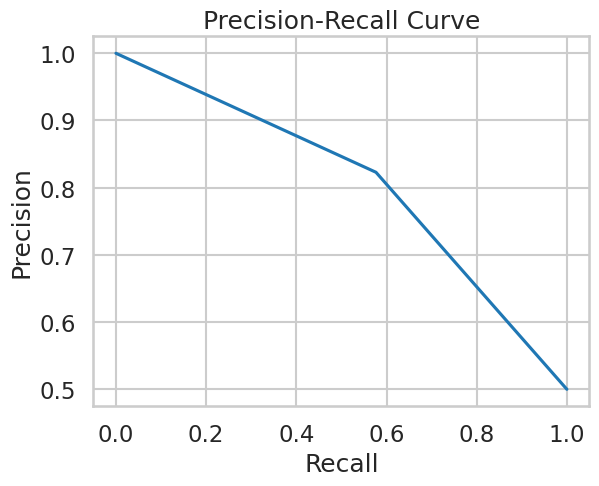

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_new, y_pred)

# Plot the Precision-Recall curve

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
